## Libraries

In [1]:
# standard libraries
import csv
import time
import numpy as np
import pandas as pd
import re
import gc
from collections import defaultdict

# data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

# Neural Network
import keras
import keras.backend as K
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


## Loading kaggle data_sets into Pandas dataframes

In [2]:
# Record total notebook run time
notebook_start = time.time()

In [3]:
print('Parsing data from TSV files...')

start_time = time.time()
df_train = pd.read_csv('Data/train.tsv', delimiter='\t', index_col=['train_id'])
df_test = pd.read_csv('Data/test.tsv', delimiter='\t', index_col=['test_id'])

print(f'Done. Took {time.time() - start_time:.2f}s')

Parsing data from TSV files...


/home/sergio/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Done. Took 12.42s


## Data fields for reference:
(from kaggle competition)

The files consist of a list of product listings. These files are tab-delimited.
* train_id or test_id - the id of the listing
* <b>name</b> - the title of the listing. Note that we have cleaned the data to remove text that look like prices to avoid leakage. These removed prices are represented as [rm]
* <b>item_condition_id</b> - the condition of the items provided by the seller, 1=Good,...,5=Poor
* <b>category_name</b> - category of the listing
* <b>brand_name</b>
* <b>price</b> - the price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column doesn't exist in test.tsv since that is what you will predict.
* <b>shipping</b> - 1 if shipping fee is paid by seller and 0 by buyer
* <b>item_description</b> - the full description of the item. Note that we have cleaned the data to remove text that look like prices to avoid leakage. These removed prices are represented as [rm]

## Data exploration - visualization

Summary so far:
 * There are unique <b>4,810</b> brands.
 * There are <b>82,489</b> items with <b>"No description yet"</b>, around 6% of our dataset. (what you think)
 * There are <b>874</b> entries with <b>price = 0/free</b>, should we drop them? as it does not make sence and will confuse our model I think.
 * prices are skewed to the right.
 * top brands (PINK, Nike, Victoria's Secret, etc)
     * Note there are <b>632,682</b> items with no brand assigned ~ 43% of our training set!

In [4]:
# check data
df_train.head(5)

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
train_id,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [5]:
# group by brands and check the most popular
brands = df_train.groupby(['brand_name']).size()

print('There are unique brands:', brands.shape[0])
print('of which {} have no brand assigned'.format(df_train[df_train['brand_name'].isnull()].shape[0]))

brands.sort_values(ascending=False).head(20)

There are unique brands: 4809
of which 632682 have no brand assigned


brand_name
PINK                 54088
Nike                 54043
Victoria's Secret    48036
LuLaRoe              31024
Apple                17322
FOREVER 21           15186
Nintendo             15007
Lululemon            14558
Michael Kors         13928
American Eagle       13254
Rae Dunn             12305
Sephora              12172
Coach                10463
Disney               10360
Bath & Body Works    10354
Adidas               10202
Funko                 9237
Under Armour          8461
Sony                  7994
Old Navy              7567
dtype: int64

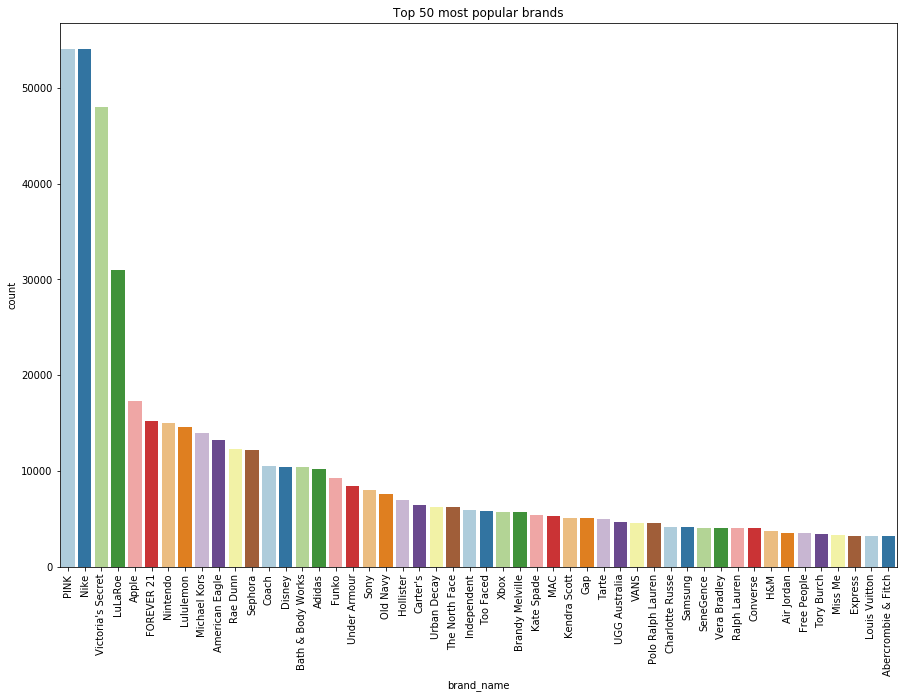

In [6]:
# Top 50 common brands
top_brands = df_train['brand_name'].value_counts()[0:50].reset_index()\
            .rename(columns={'index': 'brand_name', 'brand_name':'count'})

plt.figure(figsize=(15,10))
ax = sns.barplot(x="brand_name", y="count", data=top_brands, palette='Paired')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

# set title
ax.set_title('Top 50 most popular brands')
plt.show()

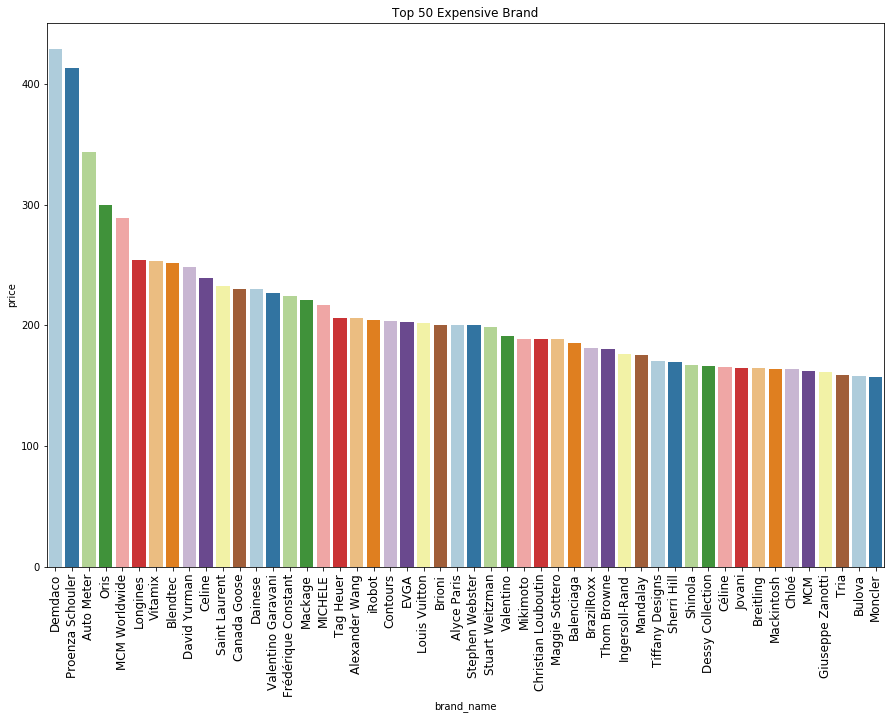

In [7]:
# Top 50 expensive brands
top_expensive = df_train.groupby('brand_name', axis=0).mean()
df_top_expensive = pd.DataFrame(top_expensive.sort_values('price', ascending = False)\
                                ['price'][0:50].reset_index())


plt.figure(figsize=(15, 10))
ax = sns.barplot(x="brand_name", y="price", data=df_top_expensive, palette='Paired')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=12)

# set title
ax.set_title('Top 50 Expensive Brand')
plt.show()

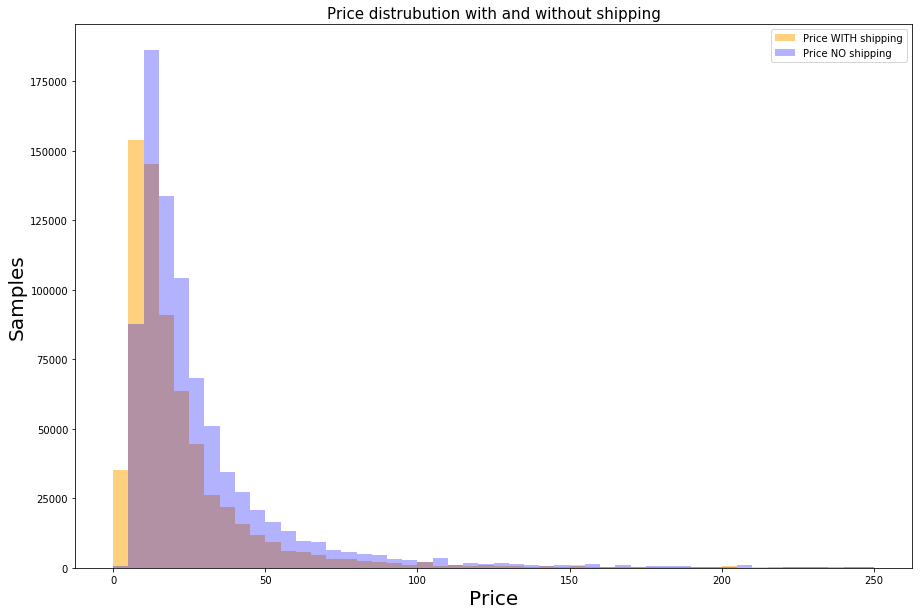

In [8]:
# price distribution for items with and without shiping
# items with no shiping tend to be a slightly more expensive

shipping = df_train[df_train['shipping']==1]['price']
no_shipping = df_train[df_train['shipping']==0]['price']

plt.figure(figsize=(15, 10))
plt.hist(shipping, bins=50, range=[0,250], alpha=0.5, label='Price WITH shipping', color='orange')
plt.hist(no_shipping, bins=50, range=[0,250], alpha=0.3, label='Price NO shipping', color='blue')
plt.title('Price distrubution with and without shipping', fontsize=15)

plt.xlabel('Price', fontsize=20)
plt.ylabel('Samples', fontsize=20)
plt.legend()

plt.show()

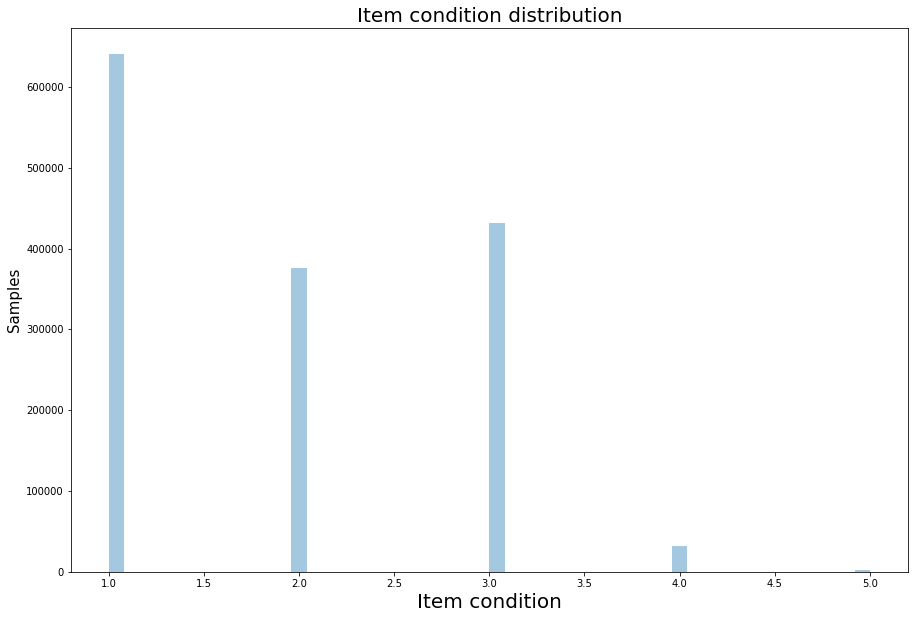

In [9]:
# item condition distribution
# Most itmes are in good condition: 1,2 and 3

plt.figure(figsize=(15, 10))

ax = sns.distplot(df_train['item_condition_id'], kde=False)
plt.title('Item condition distribution', fontsize=20)
plt.xlabel('Item condition', fontsize=20)
plt.ylabel('Samples', fontsize=15)

plt.show()

In [10]:
# items with no description
no_description = df_train[df_train['item_description']=='No description yet']
print('There are {} items with no description'.format(no_description.shape[0]))

# select top 5
no_description.head(5)

There are 82489 items with no description


,name,item_condition_id,category_name,brand_name,price,shipping,item_description
train_id,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
13,Sharpener and eraser,1,Other/Office supplies/School Supplies,Scholastic,4.0,1,No description yet
31,"New Lularoe OS leggings, stars",1,"Women/Athletic Apparel/Pants, Tights, Leggings",NaN,50.0,1,No description yet
90,Jewel holder,2,Home/Storage & Organization/Jewelry Boxes & Or...,Target,7.0,1,No description yet
117,Eyeko liquid eyeliner,1,Beauty/Makeup/Eyes,NaN,5.0,1,No description yet


<Figure size 1080x720 with 0 Axes>

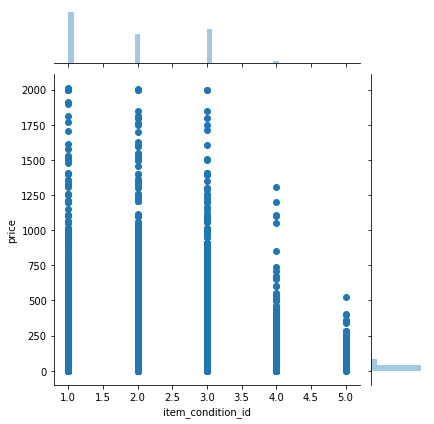

In [11]:
# looking for correlations between price and item condition
# expect to get higher price from items in condition = 1, cheaper as condition = 5
# there is not a very clear correlation other than bad (4,5) items tend to be cheaper

plt.figure(figsize=(15, 10))
sns.jointplot(x="item_condition_id", y="price", data=df_train)

plt.show()

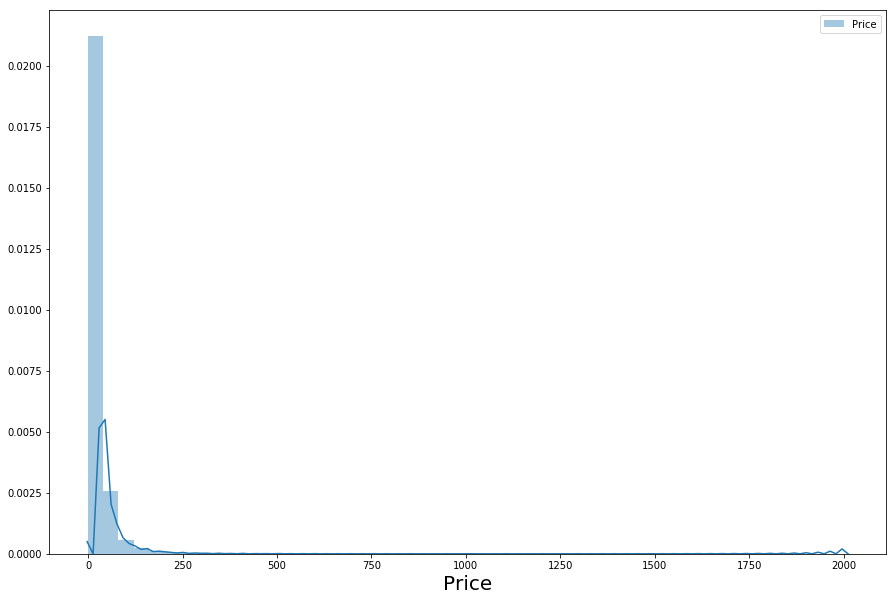

In [12]:
# Check prices, everything seems to be on the "cheaper side"
plt.figure(figsize=(15, 10))
ax = sns.distplot(df_train['price'], label='Price')
plt.xlabel('Price', fontsize=20)

plt.legend()
plt.show()

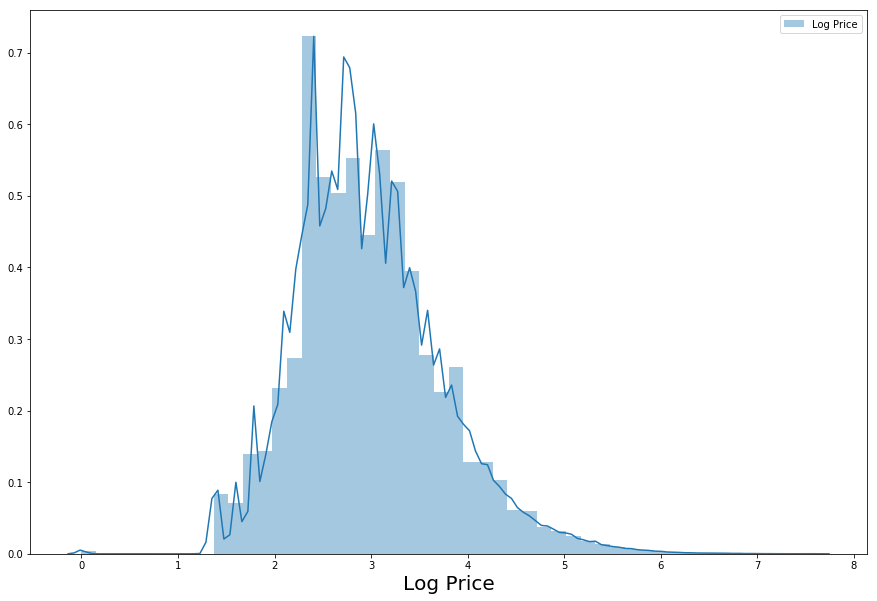

In [13]:
# Log price much better distribution
plt.figure(figsize=(15, 10))
ax = sns.distplot(np.log1p(df_train['price']), label='Log Price')
plt.xlabel('Log Price', fontsize=20)

plt.legend()
plt.show()

# Data wrangling and Cleansing

* There are <b>874</b> entries with <b>price = 0/free</b>, should we drop them? as it does not make sence and will confuse our model.
* Replace <b>NaN</b> values with empty spaces?

In [14]:
# free items??? price == 0
# not very useful

df_train[df_train['price']==0].head(5)

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
train_id,,,,,,,
1325,Alabama Crimson Tide Quality Lanyard,1,Sports & Outdoors/Fan Shop/NCAA,NaN,0.0,1,TOP QUALITY THICK LANYARD Reversible sides wit...
2544,Levi leggings,3,"Women/Jeans/Slim, Skinny",Levi's®,0.0,0,Light wash. Hardly worn. Size 24 but fits like...
2712,Simple Red Lace Lingerie Top,3,Women/Underwear/G-Strings & Thongs,NaN,0.0,0,"Very simple but cute, a little form fitting as..."
3576,Turquoise 15 Pc Makeup Brush Set,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,NaN,0.0,1,1 left!
3761,Girls size 7/8,3,Kids/Girls (4+)/Tops & T-Shirts,NaN,0.0,1,5 pair gap jean excellent used condition 3 chi...


In [15]:
# Drop entries where price is zero
initial_size = df_train.shape[0]
df_train = df_train.drop(df_train[(df_train['price'] == 0)].index)
print(f'Dropped {initial_size - df_train.shape[0]} zero-price entries')

Dropped 874 zero-price entries


In [16]:
# Replace NaN with brand unknown
df_train['brand_name'].fillna('unknown', inplace=True)
# Replace NaN and 'No description yet' with ''
df_train['item_description'] = df_train['item_description'].apply(lambda x: '' if x=='No description yet' or type(x) != str else x)

### Split categories

In [17]:
"""
# Split category into 3 columns (cat1/cat2/cat3 -> separate columns). NaN returns ''
def split_categories(category, level):
    if type(category) != str:
        return ''
    else:
        categories = category.split('/')
        return categories[level]
        
X['category1'] = X['category_name'].apply(lambda x: split_categories(x, 0))
X['category2'] = X['category_name'].apply(lambda x: split_categories(x, 1))
X['category3'] = X['category_name'].apply(lambda x: split_categories(x, 2))

X.head()
"""

def catego_to_subcategos(category_name):
    """ this function will split the category into multiple sub categories """
    
    # try as some of the entries do not have 3 categories
    try:
        category_1, category_2, category_3 = category_name.split('/')
        return category_1, category_2, category_3
    except:
        return np.nan,np.nan,np.nan
    

In [18]:
# spliting category into sub-categories
df_train['category1'],df_train['category2'],df_train['category3']=\
zip(*df_train['category_name'].apply(catego_to_subcategos))

In [19]:
# data split into sub categories
df_train.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category1,category2,category3
train_id,,,,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,unknown,10.0,1,,Men,Tops,T-shirts
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,unknown,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,unknown,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [20]:
from nltk.corpus import stopwords
eng_stp_words = stopwords.words('english')

# should we keep some words from this list?
# ('no', 'nor', 'not', 'few') do they indicate something useful like negative description?
print('full list of stop words:\n', eng_stp_words)
# 179 words
print('# words:', len(eng_stp_words))

full list of stop words:
 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own

In [21]:
# data transformation functions

def remove_stop_words(sentence):
    """ using the nltk lib, gets rid of english stopwords """
    
    sentence = ' '.join([w for w in sentence.split(' ') if w not in eng_stp_words])
    
    return sentence

def to_lower_case(sentence):
    """ returns lower case """
    
    lower_sentence = sentence.lower()
    
    return lower_sentence

def remove_numbers(sentence):
    """ removes numeric values from sentence using regular expression """
    
    sentence_no_digit = re.sub(r'\d+', '', sentence)
    
    return sentence_no_digit

def remove_special_chars(sentence):
    """ removes special characters from sentence using regular expression """
    
    # remove special characters EXCEPT white spaces
    sentence_no_spchar = re.sub(r'\W+',' ', sentence)
    
    return sentence_no_spchar

def clean_sentence(sentence):
    """ piles up cleaning functions defined by the team """
    
    # remove special characters
    sentence = remove_special_chars(sentence)
    # remove numbers
    sentence = remove_numbers(sentence)
    # lowercase
    sentence = to_lower_case(sentence)
    # remove stopwords
    sentence = remove_stop_words(sentence)

    return sentence

def clean_brand(sentence):
    """ piles up cleaning functions defined by the team """
    
    # remove special characters
    #sentence = remove_special_chars(sentence)
    # lowercase
    sentence = to_lower_case(sentence)

    return sentence

# test #
print(clean_sentence('Hello World! this is TesT 54 TO remove $ = speciaL CHars & keep words'))

hello world test  remove special chars keep words


In [22]:
# clean sentence from description and adds to new column 'item_description_cln'

# df_train['item_description'] = df_train['item_description'].apply(clean_sentence)
#df_train['name'] = df_train['name'].apply(clean_sentence)

# to help recover brand from other columns
#df_train['brand_name'] = df_train['brand_name'].apply(clean_brand)

In [23]:
# clean item description and name
#df_train.head()

In [24]:
print('Unique categories 1:', len(df_train['category1'].unique()))
print('Unique categories 2:', len(df_train['category2'].unique()))
print('Unique categories 3:', len(df_train['category3'].unique()))

# Count of category lengths
num_categories_dict = defaultdict(int)
for i, category in enumerate(df_train['category_name']):
    if type(category) != str:
        num_categories_dict['null'] += 1
        continue
    else:
        categories = category.split('/')
        num_categories = len(categories)
        num_categories_dict[num_categories] += 1
        
for k, v in num_categories_dict.items():
    print(f'Number of entries with {k} categories: {v}')

Unique categories 1: 11
Unique categories 2: 114
Unique categories 3: 865
Number of entries with 3 categories: 1470962
Number of entries with null categories: 6314
Number of entries with 5 categories: 3055
Number of entries with 4 categories: 1330


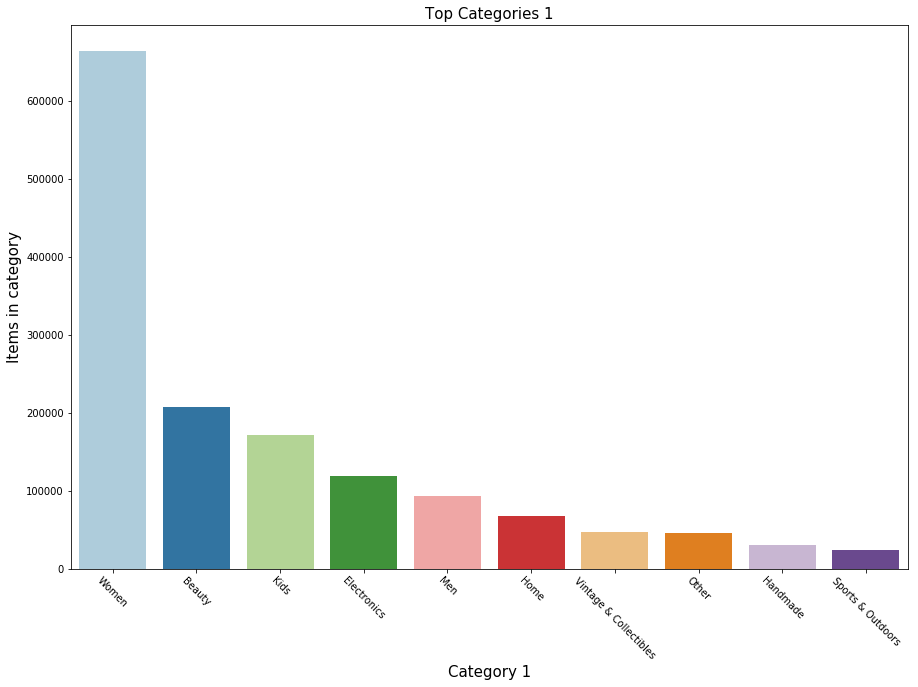

In [25]:
# There is a total of 10 category 1
plt.figure(figsize=(15, 10))
x = df_train['category1']
y = df_train['category1'].value_counts().index

sns.countplot(x, order=y, palette='Paired')

plt.title('Top Categories 1', fontsize=15)
plt.xlabel('Category 1', fontsize=15)
plt.ylabel('Items in category', fontsize=15)
plt.xticks(rotation=-45)

plt.show()

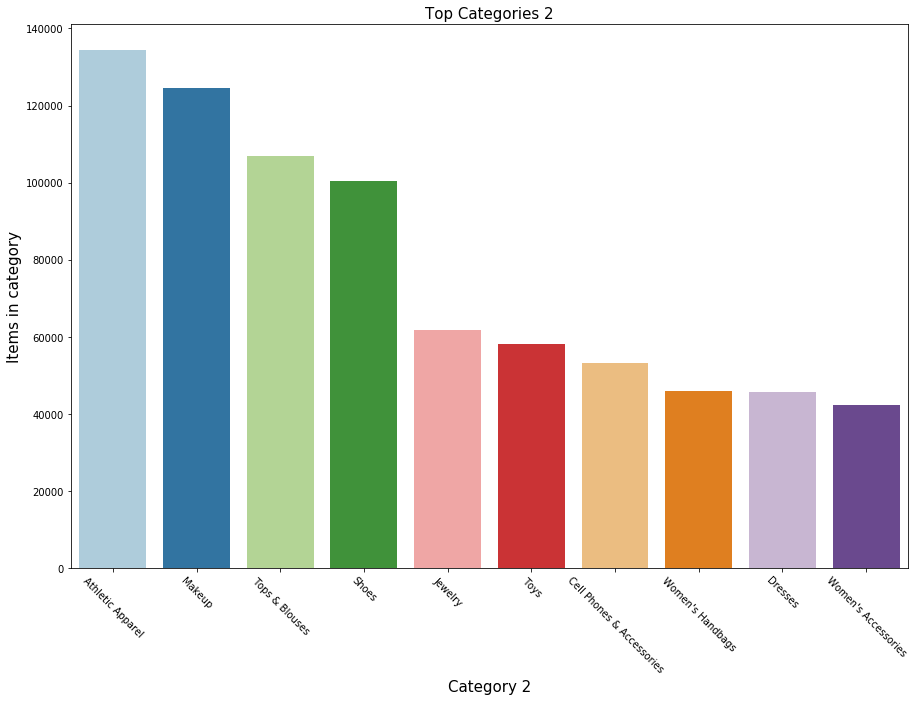

In [26]:
# plot category 2  
plt.figure(figsize=(15, 10))
x = df_train['category2']
y = df_train['category2'].value_counts().index[:10]

sns.countplot(x, order=y, palette='Paired')

plt.title('Top Categories 2', fontsize=15)
plt.xlabel('Category 2', fontsize=15)
plt.ylabel('Items in category', fontsize=15)
plt.xticks(rotation=-45)

plt.show()

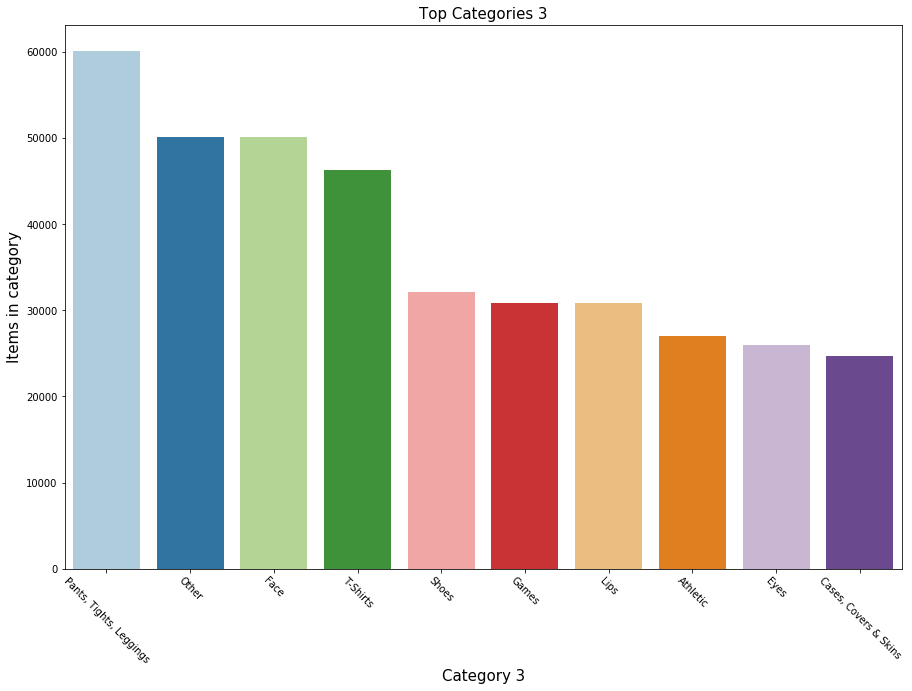

In [27]:
# plot category 3
plt.figure(figsize=(15, 10))
x = df_train['category3']
y = df_train['category3'].value_counts().index[:10]

sns.countplot(x, order=y, palette='Paired')

plt.title('Top Categories 3', fontsize=15)
plt.xlabel('Category 3', fontsize=15)
plt.ylabel('Items in category', fontsize=15)
plt.xticks(rotation=-45)

plt.show()

## X/y split

In [28]:
# We will now split the dataframe into X (features/inputs) and y (target variable).
y = df_train.loc[:, 'price']
y = pd.to_numeric(y)

X = df_train
del X['price']

X.head()

,name,item_condition_id,category_name,brand_name,shipping,item_description,category1,category2,category3
train_id,,,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,unknown,1,,Men,Tops,T-shirts
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,unknown,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,unknown,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


### Create dummy variables (one-hot encoding)

In [29]:
start_time = time.time()

print('Creating dummy variables and storing as sparse matrices...')
X_brand = csr_matrix(pd.get_dummies(X['brand_name'], sparse=True, prefix='brand'))
X_cat1 = csr_matrix(pd.get_dummies(X['category1'], sparse=True, prefix='cat1'))
X_cat2 = csr_matrix(pd.get_dummies(X['category2'], sparse=True, prefix='cat2'))
X_cat3 = csr_matrix(pd.get_dummies(X['category3'], sparse=True, prefix='cat3'))
X_cond = csr_matrix(pd.get_dummies(X['item_condition_id'], sparse=True, prefix='cond'))
X_ship = csr_matrix(pd.get_dummies(X['shipping'], sparse=True, prefix='ship'))

print(f'Done. Time taken: {time.time() - start_time:.2f}s')

Creating dummy variables and storing as sparse matrices...
Done. Time taken: 122.09s


### Transform name and item_description

In [30]:
cv_name = CountVectorizer(max_features=5000, lowercase=True, token_pattern='\w+', ngram_range=(1,1))
tv_desc = TfidfVectorizer(max_features=5000, lowercase=True, token_pattern='\w+', ngram_range=(1,2))

# Vectorise name
start_time = time.time()
print('Vectorising name...')
X_name = cv_name.fit_transform(X['name'])
print(f'Done. Time taken: {time.time() - start_time:.2f}s\n')

# Vectorise item description
start_time = time.time()
print('Vectorising item description...')
X_desc = tv_desc.fit_transform(X['item_description'])
print(f'Done. Time taken: {time.time() - start_time:.2f}s')

Vectorising name...
Done. Time taken: 8.58s

Vectorising item description...
Done. Time taken: 87.39s


### Combine features and prepare for training

In [31]:
print('Feature dimensions:')
for feature in (X_name,
                X_cond,
                X_ship,
                X_desc,
                X_brand,
                X_cat1,
                X_cat2,
                X_cat3):
    print(feature.shape)

Feature dimensions:
(1481661, 5000)
(1481661, 5)
(1481661, 2)
(1481661, 5000)
(1481661, 4808)
(1481661, 10)
(1481661, 113)
(1481661, 864)


In [32]:
start_time = time.time()
print('Creating overall input data...')

# Create final sparse matrix for X
X_input = hstack((X_name,
                  X_cond,
                  X_ship,
                  X_desc,
                  X_brand,
                  X_cat1,
                  X_cat2,
                  X_cat3)
                ).tocsr()

# y -> numpy array, then log(y+1)
y_input = np.array(y).reshape(-1,1)
y_input = np.log1p(y_input)

print(f'Done. Time taken: {time.time() - start_time:.2f}s')

Creating overall input data...
Done. Time taken: 3.50s


In [33]:
print(X_input.shape)
print(y_input.shape)

(1481661, 15802)
(1481661, 1)


In [34]:
start_time = time.time()
print('Creating train/validation split...')

X_train, X_val, y_train, y_val = train_test_split(X_input, y_input, test_size=0.1)

print(f'Done. Time taken: {time.time() - start_time:.2f}s\n')

print(f'Train shapes\nX: {X_train.shape}\nY: {y_train.shape}\n')
print(f'Validation shapes\nX: {X_val.shape}\nY: {y_val.shape}')

Creating train/validation split...
Done. Time taken: 1.78s

Train shapes
X: (1333494, 15802)
Y: (1333494, 1)

Validation shapes
X: (148167, 15802)
Y: (148167, 1)


## Neural Network

In [35]:
## Metrics
## Keras functions
def r2_metric(y, y_hat):
    RSS = K.sum(K.square(y - y_hat))
    TSS = K.sum(K.square(y - K.mean(y)))
    r2 = 1 - RSS / (TSS + K.epsilon())
    return r2

def RMSLE_metric(y, y_hat):    
    RMSLE = K.sqrt(K.mean(K.square(y_hat - y)))
    return RMSLE

## Numpy functions
def calc_r2(y, y_hat):
    RSS = np.sum((y - y_hat)**2)
    TSS = np.sum((y - np.mean(y))**2)
    r2 = 1 - RSS / TSS
    return r2

def calc_RMSLE(y, y_hat):
    RMSLE = np.sqrt(np.mean((np.log(y_hat + 1) - np.log(y + 1))**2))
    return RMSLE

In [36]:
model_input = keras.Input(shape=(X_input.shape[1],), dtype='float32', sparse=True)
hidden1 = keras.layers.Dense(192, activation='relu')(model_input)
hidden2 = keras.layers.Dense(64, activation='relu')(hidden1)
hidden3 = keras.layers.Dense(64, activation='relu')(hidden2)
model_output = keras.layers.Dense(1)(hidden3)

model = keras.Model(model_input, model_output)
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.adam(lr=3e-3), metrics=[RMSLE_metric])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 15802)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 192)               3034176   
_________________________________________________________________
dense_2 (Dense)              (None, 64)                12352     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 3,050,753
Trainable params: 3,050,753
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
epochs = 2
training_start = time.time() # 0.5036,0.4439 / 0.4071,0.4332

# Epochs done via for loop so we can increase batch size over time
for i in range(1, epochs+1): # verbose ~3.5% slower
    epoch_start = time.time()
    # print(f'Epoch {i}/{epochs}')
    model.fit(X_train, y_train, batch_size=2048*i, epochs=1, validation_data=(X_val, y_val), verbose=1,
              callbacks=[EarlyStopping(patience=1, monitor='val_loss', restore_best_weights=True)])
    print()
    # print(f'Finished. Time taken: {time.time() - epoch_start:.2f}s')
    
print(f'Training finished. Time taken: {time.time() - training_start:.2f}s')

Train on 1333494 samples, validate on 148167 samples
Epoch 1/1
1333494/1333494 [==============================] - 42s 31us/step - loss: 0.3139 - RMSLE_metric: 0.5144 - val_loss: 0.2071 - val_RMSLE_metric: 0.4550

Train on 1333494 samples, validate on 148167 samples
Epoch 1/1
1333494/1333494 [==============================] - 12s 9us/step - loss: 0.1814 - RMSLE_metric: 0.4259 - val_loss: 0.1911 - val_RMSLE_metric: 0.4371

Training finished. Time taken: 54.56s


In [38]:
# Get train/validation predictions
y_hat_train = model.predict(X_train, verbose=1)
y_hat_val = model.predict(X_val, verbose=1)

148167/148167 [==============================] - 7s 45us/step


In [40]:
# Root mean squared logarithmic error
RMSLE_train = calc_RMSLE(np.expm1(y_train), np.expm1(y_hat_train))
RMSLE_val = calc_RMSLE(np.expm1(y_val), np.expm1(y_hat_val))
print(f'RMSLE\nTrain: {RMSLE_train:.4f}\nVal: {RMSLE_val:.4f}\n')
# Best | Train: 0.3272 | Val: 0.4254 | 20k/20k CV/TV

# R squared (fraction of variance explained)
# Non-log
r2_train = calc_r2(np.expm1(y_train), np.expm1(y_hat_train))
r2_val = calc_r2(np.expm1(y_val), np.expm1(y_hat_val))
print(f'r2\nTrain: {r2_train:.4f}\nVal: {r2_val:.4f}\n')

# Log
log_r2_train = calc_r2(y_train, y_hat_train)
log_r2_val = calc_r2(y_val, y_hat_val)
print(f'log r2\nTrain: {log_r2_train:.4f}\nVal: {log_r2_val:.4f}')

RMSLE
Train: 0.3676
Val: 0.4271

r2
Train: 0.6568
Val: 0.5215

log r2
Train: 0.7571
Val: 0.6735


In [41]:
print(f'Total notebook run time: {time.time() - notebook_start:.2f}s')

Total notebook run time: 617.97s


### Ridge regression (for comparison)

In [51]:
"""# saving resources
df_train = None
cv_name = None
tv_desc = None
X_name = None
X_cond = None
X_ship = None
X_desc = None
X_brand = None
X_cat1 = None
X_cat2 = None
X_cat3 = None
X = None
gc.collect()"""

'# saving resources\ndf_train = None\ncv_name = None\ntv_desc = None\nX_name = None\nX_cond = None\nX_ship = None\nX_desc = None\nX_brand = None\nX_cat1 = None\nX_cat2 = None\nX_cat3 = None\nX = None\ngc.collect()'

In [46]:
class RidgeRegression():
    """ Ridge regression model """
    
    def __init__(self, lam=0.1):
        self.lam = lam
    
    def fit(self, X, y):
        # w = (X.T X + λI)^-1 X.Ty <-- formula
        term_1 = X.T @ X + self.lam * np.eye(X.shape[1])
        term_2 = X.T @ y
        self.w = np.linalg.inv(term_1) @ term_2

    def predict(self, X):
        prediction = X @ self.w
        prediction = np.squeeze(np.asarray(prediction))
        return np.array(prediction).reshape(-1,1)
    
    def rmsle(y, y_hat):
        rmsle = np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y_hat), 2)))
        return rmsle
    
    def set_params(self, lam=0.1):
        self.lam = lam
        return self

In [47]:
# RIDGE REGRESSION
start_time = time.time()

ridge_model = RidgeRegression()
ridge_model.fit(X_train, y_train)

print("Ridge Regression Training time: %s seconds" % (time.time() - start_time))

Ridge Regression Training time: 135.87470364570618 seconds


In [54]:
#from sklearn.linear_model import Ridge

#start_time = time.time()
#model2 = Ridge(solver='sag', fit_intercept=False)
#print('Fitting ridge regression...')
#model2.fit(X_train, y_train)
#print(f'Done. Time taken: {time.time() - start_time:.2f}s')

In [55]:
y_hat_train2 = ridge_model.predict(X_train)
y_hat_val2 = ridge_model.predict(X_val)

#y_hat_train2 = model2.predict(X_train)
#y_hat_val2 = model2.predict(X_val)

RMSLE_train2 = calc_RMSLE(np.exp(y_train), np.exp(y_hat_train2))
RMSLE_val2 = calc_RMSLE(np.exp(y_val), np.exp(y_hat_val2))

print(f'RMSLE\nTrain: {RMSLE_train2:.4f}\nVal: {RMSLE_val2:.4f}\n')

r2_train2 = calc_r2(np.exp(y_train), np.exp(y_hat_train2))
r2_val2 = calc_r2(np.exp(y_val), np.exp(y_hat_val2))

print(f'r2\nTrain: {r2_train2:.4f}\nVal: {r2_val2:.4f}\n')

log_r2_train2 = calc_r2(y_train, y_hat_train2)
log_r2_val2 = calc_r2(y_val, y_hat_val2)

print(f'log r2\nTrain: {log_r2_train2:.4f}\nVal: {log_r2_val2:.4f}')



RMSLE
Train: 0.4502
Val: 0.4539

r2
Train: 0.4247
Val: 0.4239

log r2
Train: 0.5972
Val: 0.5878
